## Problema de CBOW y skip-gram

No tiene en cuenta el **orden de las palabras**, con lo que se puede perder el significado. Además tienen un gran **coste computacional y temporal**.

## Redes neuronales recurrentes (RNN)

Las RNNs procesan **secuencias** y retienen información en una especie de "memoria" (estado). Donde $x_{i}$ y $h_{i-1}$ actúan como input para el siguiente paso, donde se produce $h_{i}$, el output en cada iteración. El output se representa como un vector de números que representa toda la frase en su contexto. De esta manera, se tiene en cuenta el contexto de la frase para producir el siguiente output.

<img src="RNN.png">

## Tipos de RNNs

- **Normal RNN**: Clasificación de imágenes (un input, un output).
- **One-to-many**: Escribir el pie de una imagen (input: imágen, output: pie de imagen con muchas palabras).
- **Many-to-one**: Clasificación de sentimientos (input: oración, output: sentimiento).
- **Many-to-many**: Traducción de textos, clasificación de cada fotograma de un vídeo...

## Problemas de las RNNs

El **gradiente** indica el ajuste a realizar en los pesos con respecto a la variación en el error. Existen dos problemas con los gradientes:

- **Gradientes explosivos**: Gradiente demasiado grande, el algoritmo asigna una importance exageradamente alta a las pesos. Tiene fácil solución truncando los gradientes.
- **Gradientes desaparecidos**: Gradientes demasiado pequeños y el modelo deja de aprender o aprende muy despacio. Sucede a menudo cuando las secuencias son relativamente **largas**. Es más difícil de solucionar.

## Long-short term memory (LSTMs)

Se plantea como una solución para retener en memoria palabras que aparecieron hace mucho tiempo (e.g. $x_{1}$ w.r.t. $x_{6}$) y no perder su información. Mantienen los valores de los gradientes suficientemente altos, realizando un entrenamiento más rápido y de mayor precisión. 

La idea es utilizar un vector a modo de peso ($\epsilon~[0,1]$) que determinará cómo de importante es la información de los pasos anteriores. Los vectores se aplican en un sistema de *puertas*. La puerta de olvido se emprlea para dterminar la importancia del output anterior $h_{i-1}$, la puerta de entrada valora la importancia de un nuevo input $x_{i}$ y la puerta de salida le aplica un peso al output producido $h_{t}$.

Otra alternativa son las llamadas **Gated Recurrent Units (GRUs)**, que tienen un rendimiento similar pero son computacionalmente más eficientes.

El problema de las LSTMs es que los cálculos se hacen en serie, palabra por palabra, lo que ralentiza mucho el entrenamiento. Si la frase es muy larga, sigue siendo un problema.

## Clasificación de texto usando LSTMs con TensorFlow

In [1]:
## Download dataset

!wget https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv

zsh:1: command not found: wget


In [1]:
## Import necessary libraries
import nltk
nltk.download('stopwords')

import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/galogonzalvo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print (tf.__version__)

2.0.0


In [3]:
## Access and visualize the dataset
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [6]:
## Create the dataset

articles = []
labels = []

with open('bbc-text.csv','r') as f:
    reader = csv.reader(f,delimiter=',')
    next(reader) # skip first line
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
        articles.append(article)
        
print(len(labels))
print(len(articles))

2225
2225


In [7]:
# This could have been done directly with pandas
for word in STOPWORDS:
    df['text'] = df['text'].apply(lambda x: x.replace(' '+word+' ',' '))

In [8]:
# Neural network parameters
vocab_size = 5000 # This is the maximum number of words to keep
embedding_dim = 64
# Padding parameters (see later for padding definition)
max_length = 200 # Maximum length of all sequences
trunc_type = 'post' #pre or post. Pad (add zeros) either before or after each sequence.
padding_type = 'post' #pre or post. Remove values larger than maximum_length either at the beginning or at the end of each sequence.
oov_tok = '<OOV>' #Used to replace out-of-vocabulary words
training_portion = 0.8

In [9]:
# Train/test split
train_size = int(df.shape[0]*training_portion)

X_train, X_test = df['text'][:train_size], df['text'][train_size:]
y_train, y_test = df['category'][:train_size], df['category'][train_size:]
print (len(X_train), len(y_train))
print (len(X_test), len(y_test))

1780 1780
445 445


In [10]:
## Create the tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train) # Updates internal vocabulary based on a list of texts
word_index = tokenizer.word_index # This returns a dictionary, where key->value = word->index. 0 is reserved for padding

In [11]:
## Convert tokens of text corpus into a sequence of integers based on the word_index dictionary (embedding)
train_sequences = tokenizer.texts_to_sequences(X_train)
#print (X_train[0])
#print (train_sequences[0])
#print (word_index['tv'])

#### Padding

Cuando los textos no tienen el mismo tamaño, hemos de usar *padding*. Esta técnica permite que diferentes piezas de texto acaben con un vector del mismo tamaño, asignando ceros hasta que todas las piezas tengan el mismo tamaño. Esto es necesario para utilizar los textos como inputs para nuestra red neuronal. 

El padding tiene un tamaño máximo que puede ser el del texto más largo, o puede estar fijado por el usuario. En este segundo caso, se pierde información pero por otro lado puede hacer el algoritmo mucho más rápido, en el caso de que tengamos un texto muy muy largo junto a textos mucho más cortos, pues para los textos cortos el vector se vería lleno de ceros sin información útil, ralentizando el proceso. En ningún caso tendremos una longitud de padding mayor que la longitud de los vectores de las *hidden layers* de la red neuronal.

In [12]:
## Create padded training data
train_padded = pad_sequences(train_sequences,
                             maxlen=max_length,
                             padding=padding_type,
                             truncating=trunc_type
                            )

print (len(train_sequences[0]))
print (len(train_padded[0]))

425
200


In [13]:
## Do the same for testing with the trained tokenizer
validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences,
                                  maxlen=max_length,
                                  padding=padding_type,
                                  truncating=trunc_type
                                 )


In [14]:
##Codify labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)

#Since we have 5 categories, this will be transformed into integer numbers from 1 to 5
train_label_sequences = np.array(label_tokenizer.texts_to_sequences(y_train))
test_label_sequences = np.array(label_tokenizer.texts_to_sequences(y_test))

In [15]:
## Decoded article (transform from list of numbers back to text)
def decode_article(text):
    reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
    return ' '.join([reverse_word_index.get(i,'?') for i in text])
print (X_train[10])
print (decode_article(train_padded[10]))

berlin cheers anti-nazi film german movie anti-nazi resistance heroine drawn loud applause berlin film festival.  sophie scholl - final days portrays final days member white rose movement. scholl  21  arrested beheaded brother  hans  1943 distributing leaflets condemning  abhorrent tyranny  adolf hitler. director marc rothemund said:  feeling responsibility keep legacy scholls going.   must somehow keep ideas alive   added.  film drew transcripts gestapo interrogations scholl trial preserved archive communist east germany secret police. discovery inspiration behind film rothemund  worked closely surviving relatives  including one scholl sisters  ensure historical accuracy film. scholl members white rose resistance group first started distributing anti-nazi leaflets summer 1942. arrested dropped leaflets munich university calling  day reckoning  adolf hitler regime. film focuses six days scholl arrest intense trial saw scholl initially deny charges ended defiant appearance. one three ge

In [16]:
np.version.version

'1.19.5'

In [17]:
## Build the neural network

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


- **Embedding layer**: Convierte enteros positivos, índices (*vocab_size*) en vectores *embedded* densos de un tamaño fijo (*embedding_dim*).
- **Bidirectional layer**: Conecta *hidden layers* de direcciones opuestas para producir el mismo output. De esta manera, el output layer puede obtener información de estados pasados (*backwards*) y del futuro (*forward*) simultáneamente.
- **LSTM layer**: Esta capa obtiene los vectores *embedded* y aplica el formalismo de la red neuronal LSTM previamente descrito. 
- **Dense layer**: Regular densely-connected NN layer. Esto es necesario para transformar estos vectores en una clasificación, en un output label. La función de activación *relu* convierte inputs negativos a 0 e inputs positivos a su valor positivo. Este número persé no tiene mucho sentido. Luego, la función *softmax* reconvierte estos números de 0 a 1 y pueden ser interpretados como una probabilidad.
    

In [18]:
#Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The **Adam algorithm** is used to optimize the model.

The loss function is chosen to be **sparse_categorical_crossentropy**, which refers to the logistic regression loss:

$J(\vec{w}) = -\frac{1}{N} \sum_{n=1}^{N} \left[ y_{n}\log\hat{y}_{n} + (1-y_{n})\log(1-\hat{y}_{n})\right]$

Metrics refers to the list of metrics to be evaluated by the model during training and testing. Typically you use the accuracy.

In [19]:
#Train the model
num_epochs = 3 #Train 3 iterations
history = model.fit(train_padded,train_label_sequences, epochs=num_epochs, validation_data=(validation_padded, test_label_sequences), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/3
1780/1780 - 82s - loss: 1.6071 - accuracy: 0.3022 - val_loss: 1.3195 - val_accuracy: 0.4584
Epoch 2/3
1780/1780 - 79s - loss: 0.6945 - accuracy: 0.7747 - val_loss: 0.4058 - val_accuracy: 0.8809
Epoch 3/3
1780/1780 - 81s - loss: 0.1954 - accuracy: 0.9416 - val_loss: 0.2439 - val_accuracy: 0.9303


The **history** object is the output of model.fit. The `history.history` attribute is a record of training/validation loss values and metrics values at successive epochs.

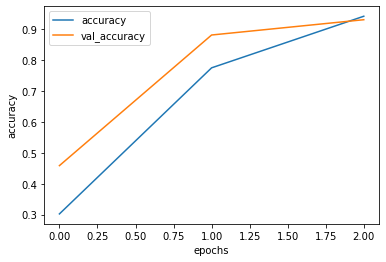

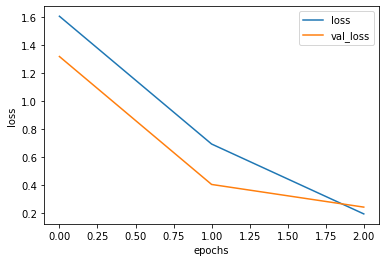

In [22]:
#Plot training results

def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()
    
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

In [26]:
#Test the model with a new text
txt = ["Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report."]
seq = tokenizer.texts_to_sequences(txt) #Convert to sequence vector using our previously trained tokenizer
padded = pad_sequences(seq,maxlen=max_length) #Apply padding
pred = model.predict(padded) #Now predict the probability for each category
print (f'Prediction for new text "{txt}" is {df["category"][np.argmax(pred)]}')

Prediction for new text "['Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report.']" is business
